# TMDB Movie Data Analysis using Pandas and APIs

### Setup and Imports


In [180]:
import os
import requests
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

### Step 1: Fetch Movie Data from API


In [181]:
# Load API key from .env file
load_dotenv(".env")
api_key = os.getenv("API_KEY")
if not api_key:
    raise ValueError("API_KEY not found.")

# Movie IDs to fetch
movie_ids = [
    0, 299534, 19995, 140607, 299536, 597, 135397, 420818,
    24428, 168259, 99861, 284054, 12445, 181808, 330457,
    351286, 109445, 321612, 260513
]
selected_movie_ids = []
for movie_id in movie_ids:
    if movie_id == 0:
        continue
    url = f"https://api.themoviedb.org/3/movie/{movie_id}?append_to_response=credits&api_key={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        selected_movie_ids.append(response.json())
    else:
        print(f"Failed to fetch movie {movie_id}: {response.status_code}")

### Store data as a Pandas DataFrame


In [182]:
# Converted DataFrame
df_movie = pd.DataFrame(selected_movie_ids)

In [183]:
# check if data is loaded correctly
df_movie['id']

df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  18 non-null     bool   
 1   backdrop_path          18 non-null     object 
 2   belongs_to_collection  16 non-null     object 
 3   budget                 18 non-null     int64  
 4   genres                 18 non-null     object 
 5   homepage               18 non-null     object 
 6   id                     18 non-null     int64  
 7   imdb_id                18 non-null     object 
 8   origin_country         18 non-null     object 
 9   original_language      18 non-null     object 
 10  original_title         18 non-null     object 
 11  overview               18 non-null     object 
 12  popularity             18 non-null     float64
 13  poster_path            18 non-null     object 
 14  production_companies   18 non-null     object 
 15  producti

In [184]:
df_movie.columns  # check column names

Index(['adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'genres',
       'homepage', 'id', 'imdb_id', 'origin_country', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'credits'],
      dtype='object')

### End of Step 1: Fetch Movie Data from API

# Step 2: Data Cleaning and Preprocessing


In [185]:
# 1: the irrelevant columns to drop
cols_to_drop = ['adult', 'imdb_id', 'original_title', 'video', 'homepage']
for col in cols_to_drop:
    # Check if the column actually exists in the DataFrame to avoid errors
    if col in cols_to_drop:
        # axis=1 refers to columns. inplace=True modifies the DataFrame directly.
        df_movie.drop(col, axis=1, inplace=True)

In [186]:
df_movie.columns  # check remaining columns names after dropping columns

Index(['backdrop_path', 'belongs_to_collection', 'budget', 'genres', 'id',
       'origin_country', 'original_language', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'vote_average', 'vote_count', 'credits'],
      dtype='object')

2. Evaluate JSON-like columns
3. Extract and clean key data points
4. Inspect extracted columns using value_counts() to identify anomalies.


In [187]:

# 2. Evaluate JSON-like columns
extracted_columns = ['belongs_to_collection', 'genres', 'spoken_languages',
                     'production_countries', 'production_companies', 'credits']

# 3. Extract and clean points
for column in extracted_columns:
    if column == 'belongs_to_collection':
        # Extracts 'name' from belongs_to_collection
        df_movie[column] = df_movie[column].apply(
            lambda x: x['name'] if isinstance(x, dict) else None)
    else:
        # Extracts other columns as pipe-separated strings
        df_movie[column] = df_movie[column].apply(lambda x: "|".join(
            [item['name'] for item in x]) if isinstance(x, list) else None)

# 4. Display value counts for each extracted column
for col in extracted_columns:
    print(f"Value counts for {col}:")
    print(df_movie[col].value_counts().head())
    print("\n")

Value counts for belongs_to_collection:
belongs_to_collection
The Avengers Collection     4
Star Wars Collection        2
Frozen Collection           2
Jurassic Park Collection    2
Avatar Collection           1
Name: count, dtype: int64


Value counts for genres:
genres
Adventure|Action|Science Fiction             3
Action|Adventure|Science Fiction|Thriller    2
Action|Adventure|Science Fiction             2
Action|Adventure|Fantasy|Science Fiction     1
Drama|Romance                                1
Name: count, dtype: int64


Value counts for spoken_languages:
spoken_languages
English                                              9
English|日本語|                                         1
English|Español                                      1
English|                                             1
English|Français|Deutsch|svenska|Italiano|Pусский    1
Name: count, dtype: int64


Value counts for production_countries:
production_countries
United States of America                   16
Unit

### Handling Missing & Incorrect Data

5. Convert Column datatypes


In [188]:
# 1. Convert column datatypes
numeric_cols = [
    'budget',
    'id',
    'popularity',
    'revenue',
    'runtime',
    'vote_average',
    'vote_count'
]

print(" Converting Data Types...")

# 2. Convert Numeric Columns
for col in numeric_cols:
    # errors='coerce' turns invalid parsing into NaN
    df_movie[col] = pd.to_numeric(df_movie[col], errors='coerce')

#  3. Convert Release Date
df_movie['release_date'] = pd.to_datetime(
    df_movie['release_date'], errors='coerce')

#  4. Verify the Changes
print("\nNew Data Types:")
print(df_movie.dtypes)

print("\nSample Data Check (First 5 rows):")
print(df_movie[['title', 'release_date', 'budget', 'revenue']].head())

 Converting Data Types...

New Data Types:
backdrop_path                    object
belongs_to_collection            object
budget                            int64
genres                           object
id                                int64
origin_country                   object
original_language                object
overview                         object
popularity                      float64
poster_path                      object
production_companies             object
production_countries             object
release_date             datetime64[ns]
revenue                           int64
runtime                           int64
spoken_languages                 object
status                           object
tagline                          object
title                            object
vote_average                    float64
vote_count                        int64
credits                          object
dtype: object

Sample Data Check (First 5 rows):
                          ti

In [189]:
df_movie.isnull().sum()  # Check for missing values in each column

backdrop_path             0
belongs_to_collection     2
budget                    0
genres                    0
id                        0
origin_country            0
original_language         0
overview                  0
popularity                0
poster_path               0
production_companies      0
production_countries      0
release_date              0
revenue                   0
runtime                   0
spoken_languages          0
status                    0
tagline                   0
title                     0
vote_average              0
vote_count                0
credits                  18
dtype: int64

6. Replace unrealistic values


In [190]:
print("--- Pre-Cleaning Statistics (Budget/Revenue/Runtime) ---")
print(df_movie[['budget', 'revenue', 'runtime']].describe())

# 1. Replace Unrealistic Values ($0 -> NaN)
target_cols = ['budget', 'revenue', 'runtime']
# Zeros in these columns imply missing data, not that the movie cost $0 or lasted 0 minutes.
df_movie[target_cols] = df_movie[target_cols].replace(0, np.nan)


# 2. Unit Conversion (Dollars -> Millions)
df_movie['budget'] = df_movie['budget'] / 1000000
# divide by 1,000,000. NaN values remain NaN automatically.
df_movie['revenue'] = df_movie['revenue'] / 1000000


# 3. Handle Zero Votes
df_movie.loc[df_movie['vote_count'] == 0, 'vote_average'] = np.nan

# 4. Clean Text Placeholders 'overview'and 'tagline'
text_placeholders = ["", "No Data", "N/A", "Unknown"]
cols_text = ['overview', 'tagline']

df_movie[cols_text] = df_movie[cols_text].replace(text_placeholders, np.nan)

# Verification
print("\n--- Post-Cleaning Preview ---")
print(df_movie[['title', 'budget', 'revenue',
      'runtime', 'vote_count', 'vote_average']].head())

print("\n--- Missing Value Count (After setting 0 to NaN) ---")
print(df_movie[['budget', 'revenue', 'runtime']].isna().sum())

--- Pre-Cleaning Statistics (Budget/Revenue/Runtime) ---
             budget       revenue     runtime
count  1.800000e+01  1.800000e+01   18.000000
mean   2.137778e+08  1.691832e+09  138.055556
std    6.195972e+07  5.210623e+08   23.848720
min    1.250000e+08  1.243226e+09  102.000000
25%    1.625000e+08  1.334902e+09  125.250000
50%    2.000000e+08  1.484542e+09  135.500000
75%    2.430000e+08  1.957196e+09  147.500000
max    3.560000e+08  2.923706e+09  194.000000

--- Post-Cleaning Preview ---
                          title  budget      revenue  runtime  vote_count  \
0             Avengers: Endgame   356.0  2799.439100      181       26983   
1                        Avatar   237.0  2923.706026      162       32888   
2  Star Wars: The Force Awakens   245.0  2068.223624      136       20107   
3        Avengers: Infinity War   300.0  2052.415039      149       31192   
4                       Titanic   200.0  2264.162353      194       26522   

   vote_average  
0         8.237  

7. Remove duplicates and drop rows with unknown 'id' or 'title'.
8. Keep only rows where at least 10 columns have non-NaN values.
9. Filter to include only 'Released' movies, then drop 'status'.


In [191]:

print(f"Rows before filtering: {df_movie.shape[0]}")

# Step 7: Remove Duplicates & Missing Identifiers
# Drop rows where 'id' or 'title' is NaN (Primary Keys)
df_movie.dropna(subset=['id', 'title'], inplace=True)

# 2. Remove Duplicate IDs (Keep the first occurrence)
df_movie.drop_duplicates(subset=['id'], inplace=True)

print(f"Rows after removing duplicates/missing IDs: {df_movie.shape[0]}")


# Step 8: Quality Threshold (Drop "Empty" Rows)
# Keep only rows with at least 10 non-NaN values.
df_movie.dropna(thresh=10, inplace=True)

print(f"Rows after threshold check (>=10 columns): {df_movie.shape[0]}")


# Step 9: Filter by Status & Clean Up
df_movie = df_movie[df_movie['status'] == 'Released'].copy()

# 2. Drop the 'status' column (Redundant now, as all are 'Released')
df_movie.drop(columns=['status'], inplace=True)

print(f"Final Row Count (Released only): {df_movie.shape[0]}")


#  Final Dataset Verification
print("\n Final Dataset Info ")
df_movie.info()

print("\n Sample of Final Data ")
print(df_movie[['title', 'release_date', 'budget', 'revenue']].head())

Rows before filtering: 18
Rows after removing duplicates/missing IDs: 18
Rows after threshold check (>=10 columns): 18
Final Row Count (Released only): 18

 Final Dataset Info 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   backdrop_path          18 non-null     object        
 1   belongs_to_collection  16 non-null     object        
 2   budget                 18 non-null     float64       
 3   genres                 18 non-null     object        
 4   id                     18 non-null     int64         
 5   origin_country         18 non-null     object        
 6   original_language      18 non-null     object        
 7   overview               18 non-null     object        
 8   popularity             18 non-null     float64       
 9   poster_path            18 non-null     object        
 10  product

### Reorder & Finalize DataFrame

10. Reorder columns
11. reset Index


In [192]:
# Reorder & Finalize DataFrame

# 1. Rename columns to match the target schema
rename_map = {
    'budget': 'budget_musd',
    'revenue': 'revenue_musd',
    'id': 'id'
}
df_movie.rename(columns=rename_map, inplace=True)

# 2. Define the Target Column Order
target_order = [
    'id', 'title', 'tagline', 'release_date', 'genres', 'belongs_to_collection',
    'original_language', 'budget_musd', 'revenue_musd', 'production_companies',
    'production_countries', 'vote_count', 'vote_average', 'popularity', 'runtime',
    'overview', 'spoken_languages', 'poster_path',
    # These will be created as NaN if missing
    'cast', 'cast_size', 'director', 'crew_size', 'credits'
]

print(" Reordering Columns ")

# 3. Reorder and Enforce Schema
# .reindex() is safer than df_movie[target_order] because it handles missing columns gracefully
df_movie = df_movie.reindex(columns=target_order)

# 4. Reset Index
df_movie.reset_index(drop=True, inplace=True)

#  Final Verification
print("\nFinal Dataframe Shape:", df_movie.shape)
print("\nColumn List:")
print(df_movie.columns.tolist())

print("\nData Preview:")
print(df_movie[['id', 'title', 'budget_musd', 'genres']].head())

 Reordering Columns 

Final Dataframe Shape: (18, 23)

Column List:
['id', 'title', 'tagline', 'release_date', 'genres', 'belongs_to_collection', 'original_language', 'budget_musd', 'revenue_musd', 'production_companies', 'production_countries', 'vote_count', 'vote_average', 'popularity', 'runtime', 'overview', 'spoken_languages', 'poster_path', 'cast', 'cast_size', 'director', 'crew_size', 'credits']

Data Preview:
       id                         title  budget_musd  \
0  299534             Avengers: Endgame        356.0   
1   19995                        Avatar        237.0   
2  140607  Star Wars: The Force Awakens        245.0   
3  299536        Avengers: Infinity War        300.0   
4     597                       Titanic        200.0   

                                     genres  
0          Adventure|Science Fiction|Action  
1  Action|Adventure|Fantasy|Science Fiction  
2          Adventure|Action|Science Fiction  
3          Adventure|Action|Science Fiction  
4            

### Export a Cleaned Movie csv


In [193]:
# Export Cleaned Data to CSV
# 1. Define the filename
output_filename = 'movies_clean.csv'

# 2. Export to CSV
print(f" Saving data to {output_filename} ")
df_movie.to_csv(output_filename, index=False)

# 3. Check if file exists and print its size to confirm success
if os.path.exists(output_filename):
    file_size = os.path.getsize(output_filename) / 1024
    print(f"Success: File saved. Size: {file_size:.2f} KB")

    # read back the first line to prove it works
    test_load = pd.read_csv(output_filename, nrows=1)
    print("\nFile Header Preview:")
    print(test_load.columns.tolist())
else:
    print("Error: File was not created.")

 Saving data to movies_clean.csv 
Success: File saved. Size: 10.04 KB

File Header Preview:
['id', 'title', 'tagline', 'release_date', 'genres', 'belongs_to_collection', 'original_language', 'budget_musd', 'revenue_musd', 'production_companies', 'production_countries', 'vote_count', 'vote_average', 'popularity', 'runtime', 'overview', 'spoken_languages', 'poster_path', 'cast', 'cast_size', 'director', 'crew_size', 'credits']


### End of Step 2

# Step 3: KPI Implementation & Analysis

Identify the Best/Worset Performing Movies


In [194]:
# Profit = Revenue - Budget
df_movie['profit_musd'] = df_movie['revenue_musd'] - df_movie['budget_musd']

# ROI = Revenue / Budget
df_movie['roi'] = df_movie['revenue_musd'] / df_movie['budget_musd']

print("KPIs Calculated: ")

# RANKING LOGIC
# def print_ranking(title, df, sort_col, ascending=False, top_n=1, cols_to_show=None):
#     if cols_to_show is None:
#         cols_to_show = ['title', 'budget_musd', 'revenue_musd', 'profit_musd', 'roi', 'vote_average']
#     if sort_col not in df.columns:
#         print(f"Skipping {title}: Column {sort_col} not found.")
#         return
#     # Sort
#     ranked = df.sort_values(by=sort_col, ascending=ascending).head(top_n)
#     print(f"\n {title} ")
#     print(ranked[cols_to_show].to_string(index=False))


def print_ranking(title, df, sort_col, ascending=False, top_n=1, cols_to_show=None):
    if cols_to_show is None:
        cols_to_show = ['title', 'budget_musd', 'revenue_musd',
                        'profit_musd', 'roi', 'vote_average']
    if sort_col not in df.columns:
        print(f"Skipping {title}: Column {sort_col} not found.")
        return

    ranked = df.sort_values(by=sort_col, ascending=ascending).head(top_n)

    # Tabulted Output
    print(f"\n{title}")
    print(tabulate(
        ranked[cols_to_show],
        headers=cols_to_show,
        tablefmt="github",
        showindex=False
    ))


# 1. Highest Revenue
print_ranking("Highest Revenue", df_movie, 'revenue_musd')

# 2. Highest Budget
print_ranking("Highest Budget", df_movie, 'budget_musd')

# 3. Highest Profit
print_ranking("Highest Profit", df_movie, 'profit_musd')

# 4. Lowest Profit
print_ranking("Lowest Profit", df_movie, 'profit_musd', ascending=True)

# 5. Highest ROI (Budget >= 10M)
high_budget_mask = df_movie['budget_musd'] >= 10
print_ranking("Highest ROI (Budget >= 10M)", df_movie[high_budget_mask], 'roi')

# 6. Lowest ROI (Budget >= 10M)
print_ranking("Lowest ROI (Budget >= 10M)",
              df_movie[high_budget_mask], 'roi', ascending=True)

# 7. Most Voted Movies
print_ranking("Most Voted Movies", df_movie, 'vote_count',
              cols_to_show=['title', 'vote_count', 'vote_average'])

# RATING RANKINGS

# 8. Highest Rated (Votes >= 10)
valid_votes_mask = df_movie['vote_count'] >= 10
print_ranking("Highest Rated (Votes >= 10)", df_movie[valid_votes_mask], 'vote_average', cols_to_show=[
              'title', 'vote_average', 'vote_count'])

# 9. Lowest Rated (Votes >= 10)
print_ranking("Lowest Rated (Votes >= 10)", df_movie[valid_votes_mask], 'vote_average', ascending=True, cols_to_show=[
              'title', 'vote_average', 'vote_count'])

# 10. Most Popular
print_ranking("Most Popular Movies", df_movie, 'popularity',
              cols_to_show=['title', 'popularity', 'genres'])

KPIs Calculated: 

Highest Revenue
| title   |   budget_musd |   revenue_musd |   profit_musd |     roi |   vote_average |
|---------|---------------|----------------|---------------|---------|----------------|
| Avatar  |           237 |        2923.71 |       2686.71 | 12.3363 |          7.594 |

Highest Budget
| title             |   budget_musd |   revenue_musd |   profit_musd |     roi |   vote_average |
|-------------------|---------------|----------------|---------------|---------|----------------|
| Avengers: Endgame |           356 |        2799.44 |       2443.44 | 7.86359 |          8.237 |

Highest Profit
| title   |   budget_musd |   revenue_musd |   profit_musd |     roi |   vote_average |
|---------|---------------|----------------|---------------|---------|----------------|
| Avatar  |           237 |        2923.71 |       2686.71 | 12.3363 |          7.594 |

Lowest Profit
| title                    |   budget_musd |   revenue_musd |   profit_musd |     roi |   vote_a

In [206]:
# extract cast and director
def get_cast(credits_data):
    """Extracts top 5 actors from the credits dictionary."""
    if isinstance(credits_data, dict) and 'cast' in credits_data:
        actors = [x['name'] for x in credits_data['cast'][:5]]
        return "|".join(actors)
    return np.nan


def get_director(credits_data):
    """Extracts the Director's name from the credits dictionary."""
    if isinstance(credits_data, dict) and 'crew' in credits_data:
        directors = [x['name']
                     for x in credits_data['crew'] if x.get('job') == 'Director']
        return "|".join(directors)
    return np.nan


print("--- Populating Cast & Director ---")
# We apply this to the raw 'credits' column
df_movie['cast'] = df_movie['credits'].apply(get_cast)
df_movie['director'] = df_movie['credits'].apply(get_director)

print("Sample Extraction:")
print(df_movie[['title', 'director', 'cast']].head(3))

--- Populating Cast & Director ---
Sample Extraction:
                          title                 director  \
0             Avengers: Endgame  Joe Russo|Anthony Russo   
1                        Avatar            James Cameron   
2  Star Wars: The Force Awakens              J.J. Abrams   

                                                cast  
0  Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...  
1  Sam Worthington|Zoe Saldaña|Sigourney Weaver|S...  
2  Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...  


In [207]:
# UDF
def rank_movies(df, criteria_col, ascending=False, top_n=5, show_cols=None):
    if show_cols is None:
        show_cols = ['title', criteria_col, 'genres', 'director', 'cast']

    # Error handling: check if column exists
    if criteria_col not in df.columns:
        return f"Error: Column '{criteria_col}' not found."

    # Sort and slice
    ranked_df = df.sort_values(
        by=criteria_col, ascending=ascending).head(top_n)

    return ranked_df[show_cols]

In [197]:
# 1. LOAD CLEAN DATA
df_clean = df_movie

# 2. DROP EXISTING 'CREDITS'
if 'credits' in df_clean.columns:
    df_clean.drop(columns=['credits'], inplace=True)

# 3. PREPARE CREDITS DATA
df_credits = pd.DataFrame(selected_movie_ids)[['id', 'credits']]

# 4. MERGE
df_movie = pd.merge(df_clean, df_credits, on='id', how='left')

# 5. DEFINE EXTRACTION FUNCTIONS


def get_cast(credits_data):
    if isinstance(credits_data, dict) and 'cast' in credits_data:
        actors = [x['name'] for x in credits_data['cast'][:5]]
        return "|".join(actors)
    return ""


def get_director(credits_data):
    if isinstance(credits_data, dict) and 'crew' in credits_data:
        directors = [x['name']
                     for x in credits_data['crew'] if x.get('job') == 'Director']
        return "|".join(directors)
    return ""


print("Repopulating Cast & Director")

# 6. APPLY EXTRACTION
df_movie['cast'] = df_movie['credits'].apply(get_cast)
df_movie['director'] = df_movie['credits'].apply(get_director)

# Verification
print(df_movie[['title', 'cast', 'director']].head())

Repopulating Cast & Director
                          title  \
0             Avengers: Endgame   
1                        Avatar   
2  Star Wars: The Force Awakens   
3        Avengers: Infinity War   
4                       Titanic   

                                                cast                 director  
0  Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...  Joe Russo|Anthony Russo  
1  Sam Worthington|Zoe Saldaña|Sigourney Weaver|S...            James Cameron  
2  Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...              J.J. Abrams  
3  Robert Downey Jr.|Chris Evans|Chris Hemsworth|...  Anthony Russo|Joe Russo  
4  Leonardo DiCaprio|Kate Winslet|Billy Zane|Kath...            James Cameron  

                          title  \
0             Avengers: Endgame   
1                        Avatar   
2  Star Wars: The Force Awakens   
3        Avengers: Infinity War   
4                       Titanic   

                                                cast                

3. Filter the dataset for specific queries


In [198]:
# Search 1
print("\nSearch 1: Bruce Willis (Sci-Fi / Action) ")
# 1. Create the Boolean Mask
search_1 = (
    df_movie['genres'].str.contains("Science Fiction", na=False) &
    df_movie['genres'].str.contains("Action", na=False) &
    df_movie['cast'].str.contains("Bruce Willis", na=False)
)

# 2. Apply Filter
bruce_movies = df_movie[search_1]

# 3. Rank Results
if not bruce_movies.empty:
    print(rank_movies(bruce_movies, criteria_col='vote_average', ascending=False))
else:
    print("No movies found for this criteria.")

# Search 2
print("\nSearch 2: Uma Thurman & Quentin Tarantino ")

# 1. Create the Boolean Mask
search_2 = (
    df_movie['cast'].str.contains("Uma Thurman", na=False) &
    df_movie['director'].str.contains("Quentin Tarantino", na=False)
)

# 2. Apply Filter
qt_movies = df_movie[search_2]

# 3. Rank Results (Sorted by runtime ascending)
if not qt_movies.empty:
    print(rank_movies(qt_movies, criteria_col='runtime', ascending=True))
else:
    print("No movies found for this criteria.")


Search 1: Bruce Willis (Sci-Fi / Action) 
No movies found for this criteria.

Search 2: Uma Thurman & Quentin Tarantino 
No movies found for this criteria.


### Franchise vs. Standalone Movie Performance

4. Compare movie franchises (belongs_to_collection) vs. standalone movies in terms of:
5. Find the Most Successful Movie Franchises based on:
6. Find the Most Successful Directors based on:


In [199]:
# Re-calculate KPI
df_movie['profit_musd'] = df_movie['revenue_musd'] - df_movie['budget_musd']
df_movie['roi'] = df_movie['revenue_musd'] / df_movie['budget_musd']


# 1. Create a "Franchise" Flag
# If belongs_to_collection has text, it's a Franchise. else it's Standalone.
df_movie['is_franchise'] = df_movie['belongs_to_collection'].notna()

# 2. Group and Aggregate
franchise_stats = df_movie.groupby('is_franchise').agg({
    'revenue_musd': 'mean',
    'roi': 'median',
    'budget_musd': 'mean',
    'popularity': 'mean',
    'vote_average': 'mean',
    'title': 'count'          # To see how many movies are in each category
}).rename(columns={'title': 'movie_count'})

# Rename the index for clarity
franchise_stats.index = ['Standalone', 'Franchise']

print("Category", franchise_stats.round(2))


print("\n 5. Most Successful Franchises ")

# Group by Collection Name
franchise_ranking = df_movie.groupby('belongs_to_collection').agg({
    'title': 'count',
    'budget_musd': ['sum', 'mean'],
    'revenue_musd': ['sum', 'mean'],
    'vote_average': 'mean'
})

# Flatten the MultiIndex columns (e.g., ('budget_musd', 'sum') -> 'budget_sum')
franchise_ranking.columns = ['_'.join(col).strip()
                             for col in franchise_ranking.columns.values]
franchise_ranking.rename(columns={'title_count': 'total_movies'}, inplace=True)

# Sort by Total Revenue (Descending)
top_franchises = franchise_ranking.sort_values(
    by='revenue_musd_sum', ascending=False)

print(top_franchises.head(5).round(2))


print("\n 6. Most Successful Directors ")

# Group by Director
director_ranking = df_movie[df_movie['director'] != ""].groupby('director').agg({
    'title': 'count',
    'revenue_musd': 'sum',
    'vote_average': 'mean'
})

director_ranking.rename(
    columns={'title': 'total_movies', 'revenue_musd': 'total_revenue'}, inplace=True)

# Sort by Total Revenue (Descending)
top_directors = director_ranking.sort_values(
    by='total_revenue', ascending=False)

print(top_directors.head(5).round(2))

Category             revenue_musd   roi  budget_musd  popularity  vote_average  \
Standalone       1765.14  9.62        180.0       19.20          7.45   
Franchise        1682.67  7.79        218.0       16.18          7.39   

            movie_count  
Standalone            2  
Franchise            16  

 5. Most Successful Franchises 
                          total_movies  budget_musd_sum  budget_musd_mean  \
belongs_to_collection                                                       
The Avengers Collection              4           1111.0            277.75   
Star Wars Collection                 2            545.0            272.50   
Jurassic Park Collection             2            320.0            160.00   
Avatar Collection                    1            237.0            237.00   
Frozen Collection                    2            300.0            150.00   

                          revenue_musd_sum  revenue_musd_mean  \
belongs_to_collection                                  

### End of Step 3

# Step 4: Data Visualization

### Use Pandas, Matplotlib to visualize


In [208]:
df_movie['is_franchise'] = df_movie['belongs_to_collection'].notna()

# Ensure numeric types
df_movie['budget_musd'] = pd.to_numeric(
    df_movie['budget_musd'], errors='coerce')
df_movie['revenue_musd'] = pd.to_numeric(
    df_movie['revenue_musd'], errors='coerce')
df_movie['popularity'] = pd.to_numeric(df_movie['popularity'], errors='coerce')
df_movie['vote_average'] = pd.to_numeric(
    df_movie['vote_average'], errors='coerce')

# Ensure Date is datetime type and extract year
df_movie['release_date'] = pd.to_datetime(df_movie['release_date'])
df_movie['release_year'] = df_movie['release_date'].dt.year

# Calculate ROI if missing
if 'roi' not in df_movie.columns:
    df_movie['roi'] = df_movie['revenue_musd'] / df_movie['budget_musd']

# Explode Genres for the ROI Chart
df_plot = df_movie.copy()
df_plot['genre_list'] = df_plot['genres'].str.split('|')
df_exploded = df_plot.explode('genre_list')

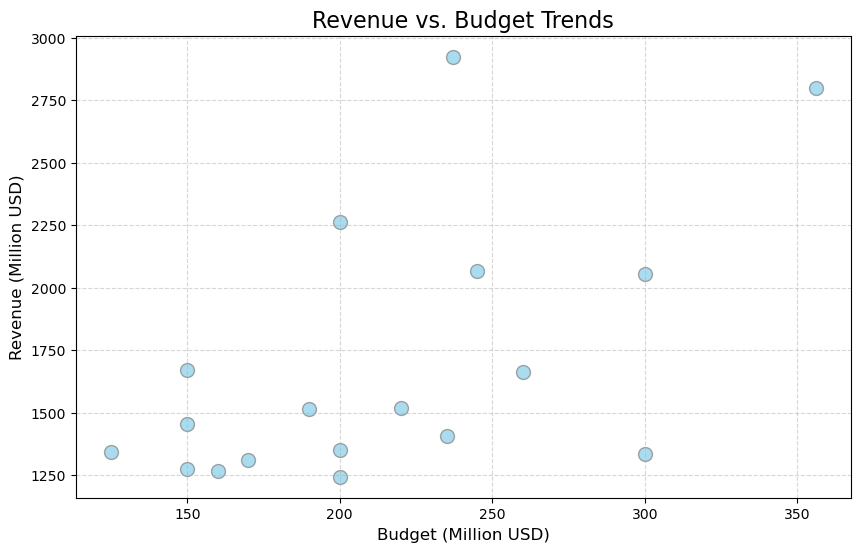

In [209]:
# 1. Revenue vs. Budget Trends (Scatter Plot)
plt.figure(figsize=(10, 6))

# Plot Standalone 
plt.scatter(
    df_movie['budget_musd'],
    df_movie['revenue_musd'],
    color='skyblue',
    alpha=0.7,
    s=100,
    edgecolors='grey'
)
plt.title('Revenue vs. Budget Trends', fontsize=16)
plt.xlabel('Budget (Million USD)', fontsize=12)
plt.ylabel('Revenue (Million USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

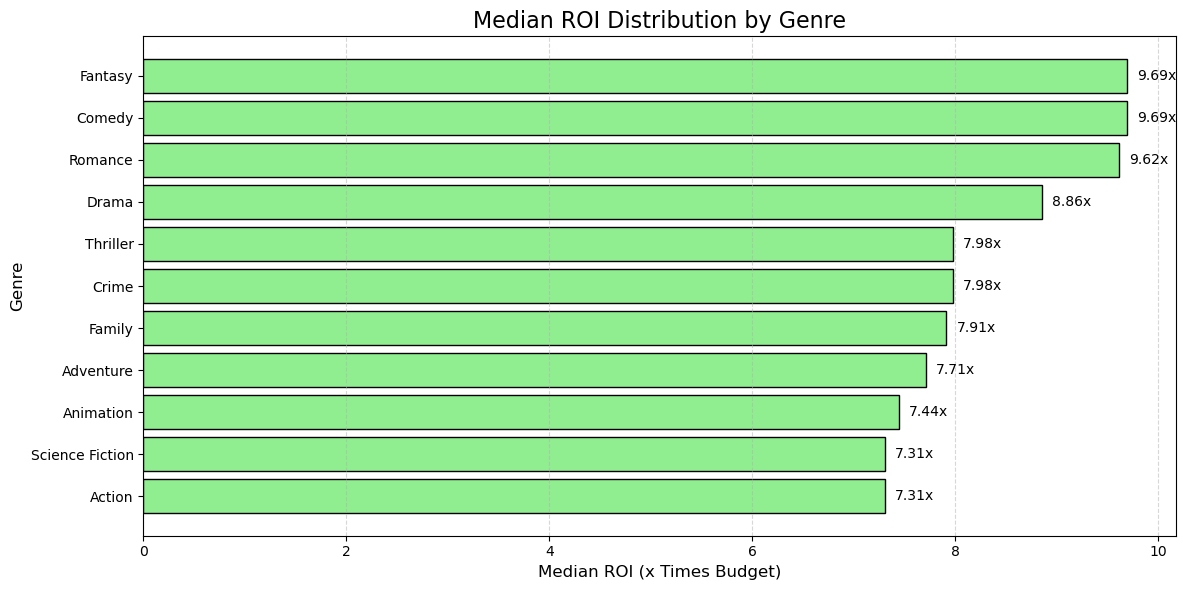

In [210]:
# 2. ROI Distribution by Genre (Bar Chart)
plt.figure(figsize=(12, 6))

# Calculate Median ROI per genre and sort
genre_roi = df_exploded.groupby('genre_list')['roi'].median().sort_values()

# Plot Horizontal Bar Chart
bars = plt.barh(genre_roi.index, genre_roi.values,
                color='lightgreen', edgecolor='black')

plt.title('Median ROI Distribution by Genre', fontsize=16)
plt.xlabel('Median ROI (x Times Budget)', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, axis='x')

# Add Labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}x', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

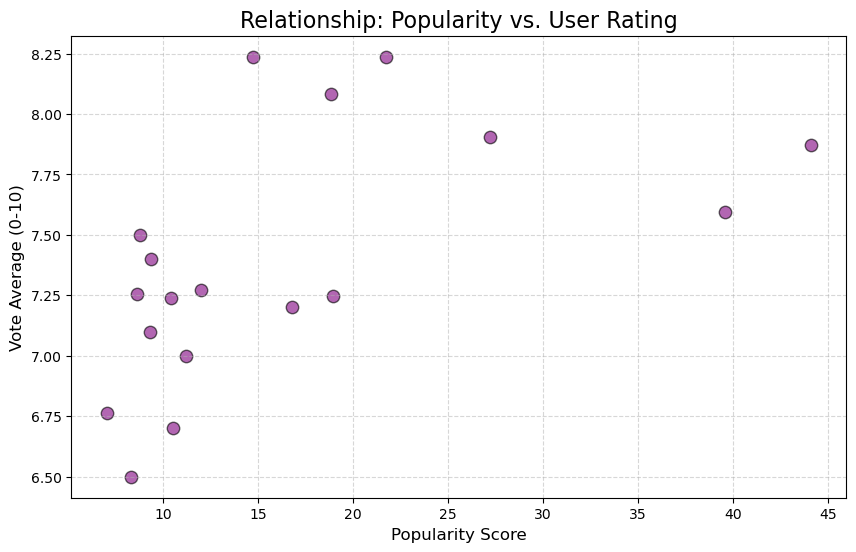

In [211]:
# 3. Popularity vs. Rating (Scatter Plot)
plt.figure(figsize=(10, 6))

plt.scatter(
    df_movie['popularity'],
    df_movie['vote_average'],
    color='purple',
    alpha=0.6,
    edgecolors='black',
    s=80
)

plt.title('Relationship: Popularity vs. User Rating', fontsize=16)
plt.xlabel('Popularity Score', fontsize=12)
plt.ylabel('Vote Average (0-10)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

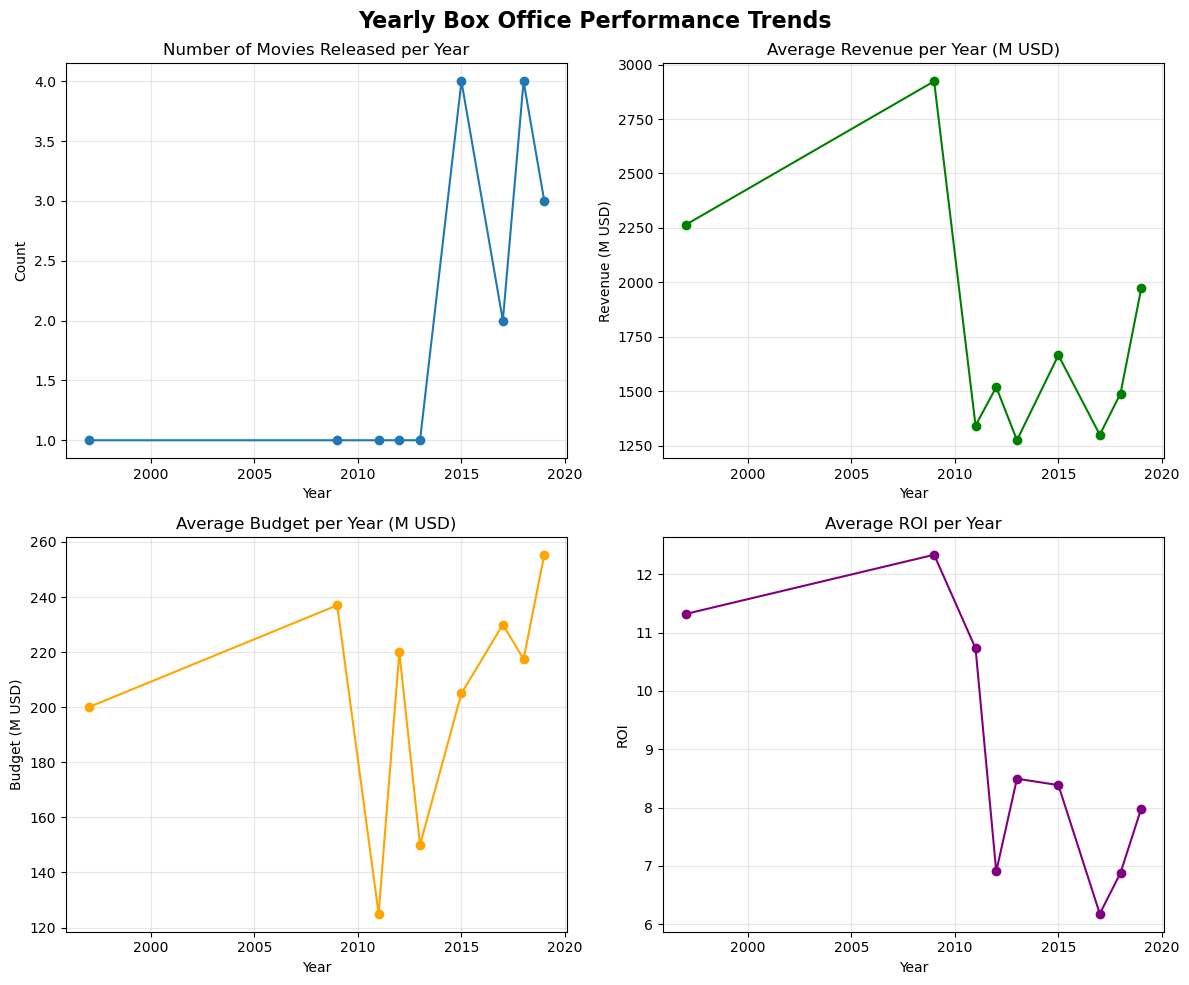

In [212]:
# 4. Yearly Trends in Box Office Performance (Line Chart)
df_movie["release_year"] = df_movie["release_date"].dt.year

# Group by year and calculate metrics
yearly_stats = df_movie.groupby("release_year").agg(
    {"revenue_musd": ["count", "mean"], "budget_musd": "mean", "roi": "mean"}
)

yearly_stats.columns = ["Movie Count",
                        "Mean Revenue", "Mean Budget", "Mean ROI"]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Yearly Box Office Performance Trends",
             fontsize=16, fontweight="bold")

# Movie Count per Year
axs[0, 0].plot(yearly_stats.index, yearly_stats["Movie Count"], marker="o")
axs[0, 0].set_title("Number of Movies Released per Year")
axs[0, 0].set_ylabel("Count")

# Average Revenue per Year
axs[0, 1].plot(
    yearly_stats.index, yearly_stats["Mean Revenue"], marker="o", color="green"
)
axs[0, 1].set_title("Average Revenue per Year (M USD)")
axs[0, 1].set_ylabel("Revenue (M USD)")

# Average Budget per Year
axs[1, 0].plot(
    yearly_stats.index, yearly_stats["Mean Budget"], marker="o", color="orange"
)
axs[1, 0].set_title("Average Budget per Year (M USD)")
axs[1, 0].set_ylabel("Budget (M USD)")

# Average ROI per Year
axs[1, 1].plot(
    yearly_stats.index, yearly_stats["Mean ROI"], marker="o", color="purple"
)
axs[1, 1].set_title("Average ROI per Year")
axs[1, 1].set_ylabel("ROI")

for ax in axs.flat:
    ax.set_xlabel("Year")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

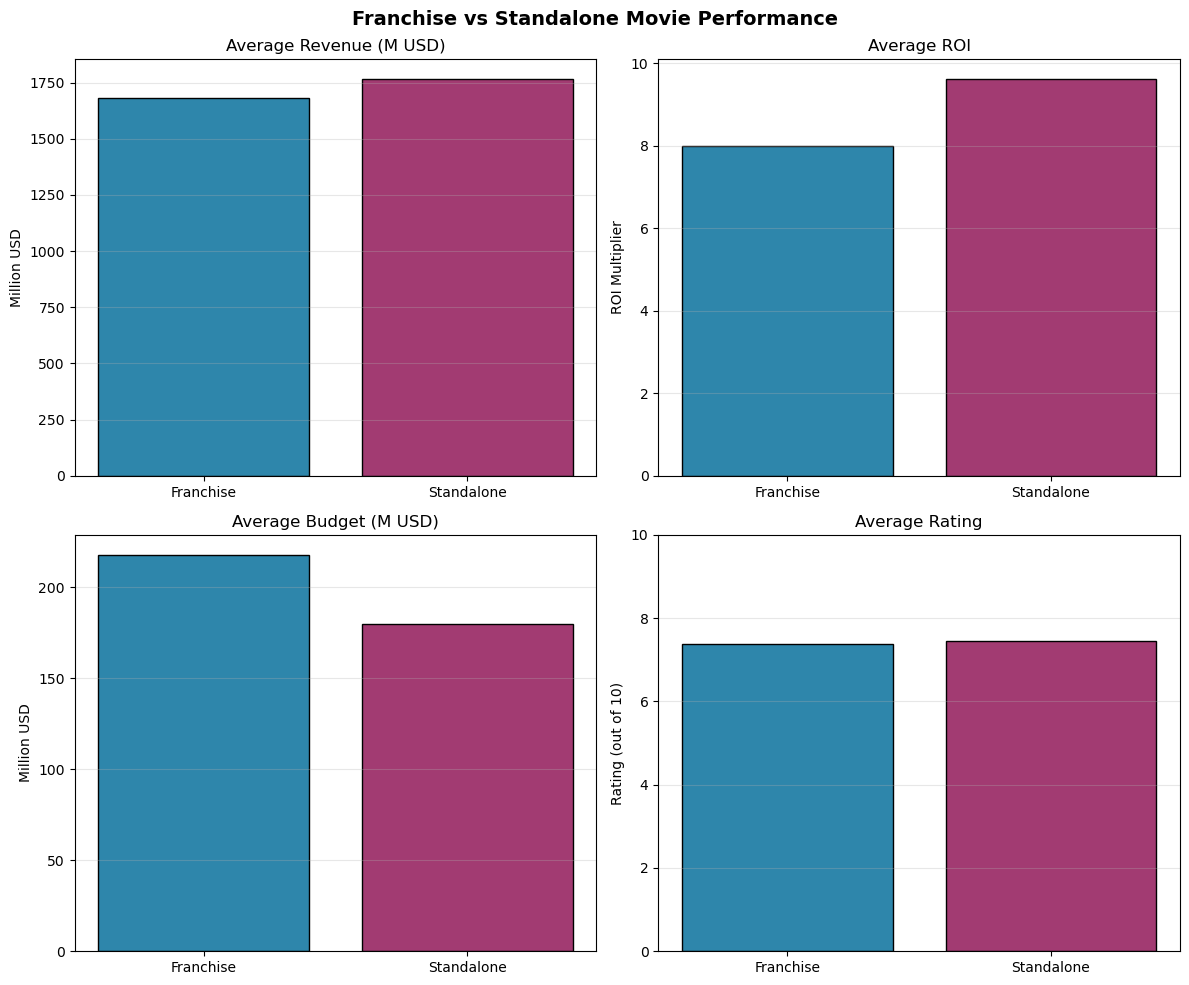

In [213]:

# 5. Franchise vs. Standalone Success (Bar Chart)
franchise_stats = df_movie[df_movie["belongs_to_collection"].notna()]
standalone = df_movie[df_movie["belongs_to_collection"].isna()]

    # calculate metrics
metrics = {
        "Revenue": [
            franchise_stats["revenue_musd"].mean(),
            standalone["revenue_musd"].mean(),
        ],
        "ROI": [franchise_stats["roi"].mean(), standalone["roi"].mean()],
        "Budget": [franchise_stats["budget_musd"].mean(), standalone["budget_musd"].mean()],
        "Rating": [franchise_stats["vote_average"].mean(), standalone["vote_average"].mean()],
    }

    # Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle(
        "Franchise vs Standalone Movie Performance", fontsize=14, fontweight="bold"
    )

categories = ["Franchise", "Standalone"]
colors = ["#2E86AB", "#A23B72"]

    # Revenue comparison
axs[0, 0].bar(categories, metrics["Revenue"], color=colors, edgecolor="black")
axs[0, 0].set_title("Average Revenue (M USD)")
axs[0, 0].set_ylabel("Million USD")
axs[0, 0].grid(True, axis="y", alpha=0.3)

    # ROI comparison
axs[0, 1].bar(categories, metrics["ROI"], color=colors, edgecolor="black")
axs[0, 1].set_title("Average ROI")
axs[0, 1].set_ylabel("ROI Multiplier")
axs[0, 1].grid(True, axis="y", alpha=0.3)

    # Budget comparison
axs[1, 0].bar(categories, metrics["Budget"], color=colors, edgecolor="black")
axs[1, 0].set_title("Average Budget (M USD)")
axs[1, 0].set_ylabel("Million USD")
axs[1, 0].grid(True, axis="y", alpha=0.3)

    # Rating comparison
axs[1, 1].bar(categories, metrics["Rating"], color=colors, edgecolor="black")
axs[1, 1].set_title("Average Rating")
axs[1, 1].set_ylabel("Rating (out of 10)")
axs[1, 1].set_ylim(0, 10)
axs[1, 1].grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


### End of Step 4